In [1]:
# Biblioteca
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [89]:
# Coordinate matrix
coord = np.array([[1, 0, 0],[2, 2, 0],[3, 0,-0.5]])
nnos = np.size(coord,0)

# Incidence matrix
inci = np.array([[1, 1, 2, 80e9, 2e-2*(4e-2)**3/12, 2e-2*4e-2],[2,2,3,80e9, 5e-3*(5e-3)**3/12, (5e-3)**2]])
nel = np.size(inci,0)

# Boundary conditions
bc = np.array([[1,1,0],[1,2,0],[1,3,0],[3,1,0],[3,2,0]])

# Mask stiffness matrix
mask = np.zeros((8,8))
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        mask[3*bc[i,0]-3,3*bc[i,0]-3] = 1
    elif bc[i,1] == 2:
        mask[3*bc[i,0]-2,3*bc[i,0]-2] = 1
    elif bc[i,1] == 3:
        mask[3*bc[i,0]-1,3*bc[i,0]-1] = 1
mask = ma.masked_equal(mask, 1)
mask = ma.mask_rowcols(mask)
mask = (mask==False)

# Mask load vector
maskv = np.zeros(8)
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        maskv[3*bc[i,0]-3] = 1
    elif bc[i,1] == 2:
        maskv[3*bc[i,0]-2] = 1
    elif bc[i,1] == 3:
        maskv[3*bc[i,0]-1] = 1
maskv = ma.masked_equal(maskv, 1)
maskv = (maskv==False)

#  Load vector
qx = 0
qy = 10e3
L = 2

f = np.array([[qx*L/2],[qy*L/2], [qy*L**2/12], [qx*L/2],[qy*L/2], [-qy*L**2/12], [0],[0]])

kg = np.zeros((3*(nnos-1)+2,3*(nnos-1)+2)) # global stiffness matrix pre-allocation

# Global matrix assembly
i = 0
node1 = inci[i,1] # first node element
node2 = inci[i,2] # second node element

x1 = coord[int(node1) - 1, 1]
x2 = coord[int(node2) - 1, 1]

y1 = coord[int(node1) - 1, 2]
y2 = coord[int(node2) - 1, 2]

# local stiffness matrix
inertia = inci[i,4]
E = inci[i,3] 
A = inci[i,5]
l = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

ke = E/l**3*np.array([[A*l**2, 0, 0,-A*l**2, 0, 0], [0, 12*inertia, 6*l*inertia, 0,-12*inertia, 6*l*inertia], [0, 6*l*inertia, 4*l**2*inertia, 0, -6*l*inertia, 2*l**2*inertia], [-A*l**2, 0, 0,A*l**2, 0, 0], [0, -12*inertia, -6*l*inertia, 0, 12*inertia, -6*l*inertia], [0, 6*l*inertia, 2*l**2*inertia,0, -6*l*inertia, 4*l**2*inertia] ])

# localization vector
loc = [3*node1-3,3*node1-2, 3*node1-1,3*node2-3, 3*node2-2,3*node2-1]
    
# global stiffness matrix 
kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])], [int(loc[4])], [int(loc[5])] ], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3]), int(loc[4]), int(loc[5])]] = kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])], [int(loc[4])], [int(loc[5])] ], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3]), int(loc[4]), int(loc[5])]] + ke

i = 1
node1 = inci[i,1] # first node element
node2 = inci[i,2] # second node element

x1 = coord[int(node1) - 1, 1]
x2 = coord[int(node2) - 1, 1]

y1 = coord[int(node1) - 1, 2]
y2 = coord[int(node2) - 1, 2]

if (x2-x1) ==0:
    if y2 > y1:
        theta = 2*np.arctan(1)
    else:
        theta =-2*np.arctan(1)
else:
    theta = np.arctan((y2-y1)/(x2-x1))

c = np.cos(theta)
s = np.sin(theta)

inertia = inci[i,4]
E = inci[i,3] 
A = inci[i,5]
l = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# local stiffness matrix
ke = E*A/l*np.array([[c**2, c*s, -c**2, -c*s], [c*s, s**2, -c*s, -s**2], [-c**2, -c*s, c**2, c*s], [-c*s, -s**2, c*s, s**2]])

# localization vector
loc = [3*node1-3,3*node1-2,3*node2-3, 3*node2-2]

# global stiffness matrix 
kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] +  ke


kg_aux = kg[mask.data]
kg_aux = np.reshape(kg_aux, (2*nnos-np.size(bc,1), 2*nnos-np.size(bc,1)))
f_aux  = f[maskv.data]

# displacement
u = np.zeros((8, 1))
u[maskv.data] = np.linalg.solve(kg_aux, f_aux)
u_ = u[[0,1,3,4,6,7]]
u_ = np.reshape(u_,(nnos,2))


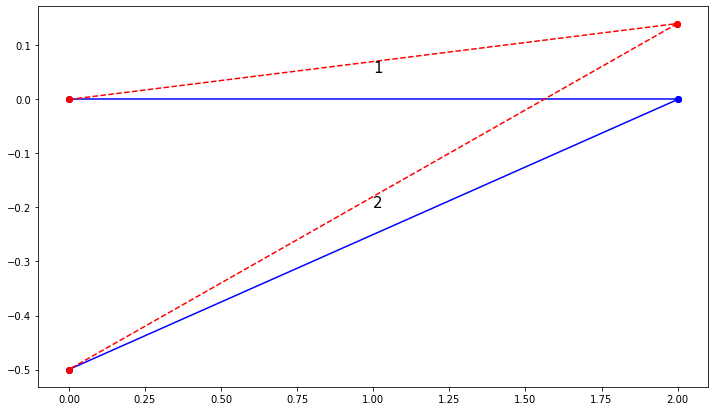

In [97]:
factor = 1.1
new_coord = coord[:,1:3] + factor*u_

fig, ax = plt.subplots(figsize = (12, 7))

# original truss
for i in range(0, np.size(inci,0)):
    x1 = coord[int(inci[i,1]-1), 1]
    x2 = coord[int(inci[i,2]-1), 1]
    
    y1 = coord[int(inci[i,1]-1), 2]
    y2 = coord[int(inci[i,2]-1), 2]
    
    plt.plot([x1,x2], [y1,y2], 'bo-')
    
    s  = "{}".format(i+1)
    plt.text((x1+x2)/2, (y1+y2)/2 + 0.05, s, fontsize = 15)
    
# deformed truss
for i in range(0, np.size(inci,0)):
    x1 = new_coord[int(inci[i,1]-1), 0]
    x2 = new_coord[int(inci[i,2]-1), 0]
    
    y1 = new_coord[int(inci[i,1]-1), 1]
    y2 = new_coord[int(inci[i,2]-1), 1]
    
    plt.plot([x1,x2], [y1,y2], 'ro--')    
    
fig.savefig('fem2_2.png',dpi=300)                              # salvar figura como png (dpi = número de pixels)